[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data-augmentation/GANs-CNN.ipynb)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision.utils import make_grid

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
LATENT_DIM = 64 # noisy input dimentions
IM_CHANNELS = 1 # no of channels in image = 1 cause black and white
IM_SIZE = (28, 28)

cuda


# Dataset

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True) # loading the downloaded dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 143039968.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29035401.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 39206178.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7003870.87it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



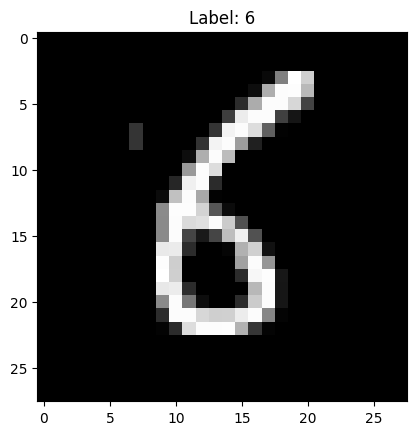

In [ ]:
# Display one image from one of the batches
images, labels = next(iter(mnist_loader)) # Extract one batch of images and labels
image = images[0].numpy().squeeze() # loading the one image from that batch
label = labels[0].item() # loading the actual label of the above image

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# Modelling

In [ ]:
class Generator(nn.Module):

    def __init__(self, latent_dim, im_size, im_channels):
        super().__init__()
        self.latent_dim = latent_dim
        self.im_size = im_size
        self.im_channels = im_channels

        layer_1 = nn.Sequential(nn.ConvTranspose2d(100, 512, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(512),nn.ReLU())
        layer_2 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(256),nn.ReLU())
        layer_3 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.BatchNorm2d(128),nn.ReLU())
        layer_4 = nn.Sequential(nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.Identity(),nn.Tanh())
        self.layers = nn.ModuleList([layer_1, layer_2, layer_3, layer_4])

    def forward(self, z):
        batch_size = z.shape[0]
        out = z.reshape(-1, self.latent_dim, 1, 1)
        for layer in self.layers:
            out = layer(out)
        out = out.reshape(batch_size, self.im_channels, self.im_size, self.im_size)
        return out

In [ ]:
'''class Generator(nn.Module):

    def __init__(self, latent_dim, im_size, im_channels):
        super().__init__()
        self.latent_dim = latent_dim
        self.im_size = im_size
        self.im_channels = im_channels

        # encoder
        self.encoder_layer_1 = nn.Sequential(nn.Conv2d(100, 128, kernel_size=2, stride=2, padding=1, bias=False), nn.BatchNorm2d(128),nn.ReLU())
        self.encoder_layer_2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256),nn.ReLU())
        self.encoder_layer_3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(512),nn.ReLU())

        # decoder
        self.decoder_layer_1 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(256),nn.ReLU())
        self.decoder_layer_2 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.BatchNorm2d(128),nn.ReLU())
        self.decoder_layer_3 = nn.Sequential(nn.ConvTranspose2d(128, 100, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.BatchNorm2d(100),nn.ReLU())
        self.decoder_layer_4 = nn.Sequential(nn.ConvTranspose2d(100, 1, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.Identity(),nn.Tanh())


    def forward(self, z):
        #batch_size = z.shape[0]
        out = z.reshape(-1, self.latent_dim, 1, 1)

        #encoder forward pass
        out = self.encoder_layer_1(out)
        out = self.encoder_layer_2(out)
        out = self.encoder_layer_3(out)

        #decoder forward pass
        out = self.decoder_layer_1(out)
        out = self.decoder_layer_2(out)
        out = self.decoder_layer_3(out)
        out = self.decoder_layer_4(out)

        #out = out.reshape(batch_size, self.im_channels, self.im_size, self.im_size)
        return out'''

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        layer_1 = nn.Sequential(nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=True), nn.Identity(),nn.LeakyReLU())
        layer_2 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256),nn.LeakyReLU())
        layer_3 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512),nn.LeakyReLU())
        layer_4 = nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False), nn.Identity(),nn.Sigmoid())
        self.layers = nn.ModuleList([layer_1, layer_2, layer_3, layer_4])

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out.reshape(x.size(0))

# Training

In [ ]:
from torch.optim import Adam

# Instantiate generator model
im_channels = 1
im_size = 28
latent_dim = 100
generator = Generator(latent_dim, im_size, im_channels).to(device)
generator.train()
optimizer_generator = Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999)) #0.5 is momentum

# Instantiate discriminator model
discriminator = Discriminator().to(device)
discriminator.train()
optimizer_discriminator = Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999)) #0.5 is momentum

100%|██████████| 938/938 [01:05<00:00, 14.23it/s]


Finished epoch:1 | Generator Loss : 2.503188190953945 | Discriminator Loss : 0.7580347837329701 | Discriminator real pred : 0.6754912188185304 | Discriminator fake pred : 0.5626828139270547


100%|██████████| 938/938 [01:01<00:00, 15.36it/s]


Finished epoch:2 | Generator Loss : 2.25579791905275 | Discriminator Loss : 0.6502990859912149 | Discriminator real pred : 0.6824735896165437 | Discriminator fake pred : 0.5551493343895179


100%|██████████| 938/938 [00:59<00:00, 15.70it/s]


Finished epoch:3 | Generator Loss : 2.6585887193298543 | Discriminator Loss : 0.5402850789873839 | Discriminator real pred : 0.6910418510945366 | Discriminator fake pred : 0.5456341450402478


100%|██████████| 938/938 [00:59<00:00, 15.67it/s]


Finished epoch:4 | Generator Loss : 3.003347297085882 | Discriminator Loss : 0.4497507660786734 | Discriminator real pred : 0.6978148119663125 | Discriminator fake pred : 0.5379847680200646


100%|██████████| 938/938 [00:59<00:00, 15.71it/s]


Finished epoch:5 | Generator Loss : 3.3787299327568205 | Discriminator Loss : 0.35163088532875597 | Discriminator real pred : 0.7048458854145587 | Discriminator fake pred : 0.5301149758829999


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:6 | Generator Loss : 3.6891203154124685 | Discriminator Loss : 0.3170478659938139 | Discriminator real pred : 0.7078177555918947 | Discriminator fake pred : 0.5267255089557501


100%|██████████| 938/938 [00:59<00:00, 15.71it/s]


Finished epoch:7 | Generator Loss : 3.812298933770865 | Discriminator Loss : 0.3131480474374505 | Discriminator real pred : 0.7084947441940876 | Discriminator fake pred : 0.5258768149403367


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:8 | Generator Loss : 4.100324355018165 | Discriminator Loss : 0.2693283506043589 | Discriminator real pred : 0.7118623765673973 | Discriminator fake pred : 0.5221242592024651


100%|██████████| 938/938 [00:59<00:00, 15.65it/s]


Finished epoch:9 | Generator Loss : 4.129707538528737 | Discriminator Loss : 0.26527873359159876 | Discriminator real pred : 0.7124591904408388 | Discriminator fake pred : 0.5213880180550028


100%|██████████| 938/938 [00:59<00:00, 15.67it/s]


Finished epoch:10 | Generator Loss : 4.333658885409329 | Discriminator Loss : 0.24310037308533403 | Discriminator real pred : 0.7137120691443811 | Discriminator fake pred : 0.5199429920868579


100%|██████████| 938/938 [00:59<00:00, 15.65it/s]


Finished epoch:11 | Generator Loss : 4.48319572718667 | Discriminator Loss : 0.2290118576160499 | Discriminator real pred : 0.714890940865474 | Discriminator fake pred : 0.5186150408248658


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:12 | Generator Loss : 4.505787388951794 | Discriminator Loss : 0.21518974158781837 | Discriminator real pred : 0.7154298617260288 | Discriminator fake pred : 0.51802070079836


100%|██████████| 938/938 [00:59<00:00, 15.64it/s]


Finished epoch:13 | Generator Loss : 4.9438729635052585 | Discriminator Loss : 0.17213220967611334 | Discriminator real pred : 0.7184861169568003 | Discriminator fake pred : 0.5145973987035406


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:14 | Generator Loss : 4.850179499559311 | Discriminator Loss : 0.1945485299322079 | Discriminator real pred : 0.7174098248293659 | Discriminator fake pred : 0.5156546941062788


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:15 | Generator Loss : 4.883568222493505 | Discriminator Loss : 0.17420025940920944 | Discriminator real pred : 0.718878688652124 | Discriminator fake pred : 0.5141449355240315


100%|██████████| 938/938 [01:00<00:00, 15.62it/s]


Finished epoch:16 | Generator Loss : 4.9936256384703395 | Discriminator Loss : 0.2042959346545181 | Discriminator real pred : 0.7174898989673363 | Discriminator fake pred : 0.5156092052139453


100%|██████████| 938/938 [00:59<00:00, 15.70it/s]


Finished epoch:17 | Generator Loss : 5.126255643266096 | Discriminator Loss : 0.1562856898058766 | Discriminator real pred : 0.7200601134600162 | Discriminator fake pred : 0.5126955939381361


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:18 | Generator Loss : 5.209117289831135 | Discriminator Loss : 0.16962709343299143 | Discriminator real pred : 0.7194399027300796 | Discriminator fake pred : 0.5133884514826955


100%|██████████| 938/938 [00:59<00:00, 15.64it/s]


Finished epoch:19 | Generator Loss : 5.272087988568775 | Discriminator Loss : 0.1519260522537132 | Discriminator real pred : 0.7204718950714892 | Discriminator fake pred : 0.5121816001467104


100%|██████████| 938/938 [01:00<00:00, 15.53it/s]


Finished epoch:20 | Generator Loss : 5.312715217058084 | Discriminator Loss : 0.17237415015963076 | Discriminator real pred : 0.7196336377785404 | Discriminator fake pred : 0.5130485444307835


100%|██████████| 938/938 [01:00<00:00, 15.60it/s]


Finished epoch:21 | Generator Loss : 5.1961232680183995 | Discriminator Loss : 0.16270304445985523 | Discriminator real pred : 0.7201359048962339 | Discriminator fake pred : 0.5125884106164293


100%|██████████| 938/938 [01:00<00:00, 15.62it/s]


Finished epoch:22 | Generator Loss : 5.3866875563730305 | Discriminator Loss : 0.14510791407459214 | Discriminator real pred : 0.7209050213095984 | Discriminator fake pred : 0.5117572188885735


100%|██████████| 938/938 [00:59<00:00, 15.74it/s]


Finished epoch:23 | Generator Loss : 5.712175330500613 | Discriminator Loss : 0.10077641703419761 | Discriminator real pred : 0.7236211459392677 | Discriminator fake pred : 0.5087297270928365


100%|██████████| 938/938 [00:59<00:00, 15.67it/s]


Finished epoch:24 | Generator Loss : 5.493608181124557 | Discriminator Loss : 0.15545834805061823 | Discriminator real pred : 0.7205657872563994 | Discriminator fake pred : 0.5119990788416059


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:25 | Generator Loss : 5.616693603522234 | Discriminator Loss : 0.14574493348587558 | Discriminator real pred : 0.7213149651535539 | Discriminator fake pred : 0.5111923161854368


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:26 | Generator Loss : 5.878003385593134 | Discriminator Loss : 0.10388079076781491 | Discriminator real pred : 0.7239364153667808 | Discriminator fake pred : 0.508257783298045


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:27 | Generator Loss : 5.882239669402525 | Discriminator Loss : 0.12578753773100687 | Discriminator real pred : 0.7227218452928417 | Discriminator fake pred : 0.5095914012587655


100%|██████████| 938/938 [00:59<00:00, 15.70it/s]


Finished epoch:28 | Generator Loss : 5.806169903163971 | Discriminator Loss : 0.10740383071484846 | Discriminator real pred : 0.7235921091362357 | Discriminator fake pred : 0.5086371121503143


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:29 | Generator Loss : 5.917172788699934 | Discriminator Loss : 0.12297330038188381 | Discriminator real pred : 0.7226519711744557 | Discriminator fake pred : 0.5097138937602419


100%|██████████| 938/938 [00:59<00:00, 15.64it/s]


Finished epoch:30 | Generator Loss : 6.04842162100491 | Discriminator Loss : 0.12272858356154447 | Discriminator real pred : 0.7232871883586526 | Discriminator fake pred : 0.5089172483253073


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:31 | Generator Loss : 5.980815060230206 | Discriminator Loss : 0.1229038482006547 | Discriminator real pred : 0.7229545656551939 | Discriminator fake pred : 0.5092997195751174


100%|██████████| 938/938 [00:59<00:00, 15.73it/s]


Finished epoch:32 | Generator Loss : 6.204341760671723 | Discriminator Loss : 0.06931730785056142 | Discriminator real pred : 0.725845409100498 | Discriminator fake pred : 0.5060949033892739


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:33 | Generator Loss : 5.972246968892337 | Discriminator Loss : 0.1403341011430853 | Discriminator real pred : 0.7225180439222088 | Discriminator fake pred : 0.5096336253670487


100%|██████████| 938/938 [00:59<00:00, 15.72it/s]


Finished epoch:34 | Generator Loss : 6.044884248662478 | Discriminator Loss : 0.10740522650030276 | Discriminator real pred : 0.7240006930029976 | Discriminator fake pred : 0.5081597899577257


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:35 | Generator Loss : 6.170092014873873 | Discriminator Loss : 0.10890750401157188 | Discriminator real pred : 0.724261327720146 | Discriminator fake pred : 0.5078391191293435


100%|██████████| 938/938 [01:00<00:00, 15.57it/s]


Finished epoch:36 | Generator Loss : 6.3084687032043805 | Discriminator Loss : 0.10287424200493693 | Discriminator real pred : 0.7245539263494487 | Discriminator fake pred : 0.5074421164196438


100%|██████████| 938/938 [00:59<00:00, 15.68it/s]


Finished epoch:37 | Generator Loss : 6.381284629938 | Discriminator Loss : 0.09561834028171899 | Discriminator real pred : 0.7250496429929347 | Discriminator fake pred : 0.5069170146227391


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


Finished epoch:38 | Generator Loss : 6.475684341654849 | Discriminator Loss : 0.08304917811999904 | Discriminator real pred : 0.725238170196761 | Discriminator fake pred : 0.5067614280720001


100%|██████████| 938/938 [00:59<00:00, 15.71it/s]


Finished epoch:39 | Generator Loss : 6.352368048704001 | Discriminator Loss : 0.10439436781776897 | Discriminator real pred : 0.724641264946476 | Discriminator fake pred : 0.5073154609976038


100%|██████████| 938/938 [00:59<00:00, 15.67it/s]


Finished epoch:40 | Generator Loss : 6.282376618924807 | Discriminator Loss : 0.09420350299291025 | Discriminator real pred : 0.7248986952467513 | Discriminator fake pred : 0.5070755177977752


100%|██████████| 938/938 [00:59<00:00, 15.68it/s]


Finished epoch:41 | Generator Loss : 6.505312682087742 | Discriminator Loss : 0.09152679803399201 | Discriminator real pred : 0.7251721959886774 | Discriminator fake pred : 0.5067399929581421


100%|██████████| 938/938 [01:00<00:00, 15.61it/s]


Finished epoch:42 | Generator Loss : 6.407066586747098 | Discriminator Loss : 0.09629855063040929 | Discriminator real pred : 0.7250742787110017 | Discriminator fake pred : 0.5068551588541409


100%|██████████| 938/938 [00:59<00:00, 15.73it/s]


Finished epoch:43 | Generator Loss : 6.623531603991096 | Discriminator Loss : 0.06961465943976573 | Discriminator real pred : 0.7265852811748285 | Discriminator fake pred : 0.505118721774392


100%|██████████| 938/938 [00:59<00:00, 15.66it/s]


Finished epoch:44 | Generator Loss : 6.408961069927033 | Discriminator Loss : 0.09883687669015204 | Discriminator real pred : 0.7248914517573456 | Discriminator fake pred : 0.5070669041640723


100%|██████████| 938/938 [00:59<00:00, 15.72it/s]


Finished epoch:45 | Generator Loss : 6.367278916336326 | Discriminator Loss : 0.09587533710513767 | Discriminator real pred : 0.7251005657573244 | Discriminator fake pred : 0.5067793849561768


100%|██████████| 938/938 [00:59<00:00, 15.70it/s]


Finished epoch:46 | Generator Loss : 6.688136363848805 | Discriminator Loss : 0.10087627970783819 | Discriminator real pred : 0.7254407421103927 | Discriminator fake pred : 0.5065031856107813


100%|██████████| 938/938 [00:59<00:00, 15.68it/s]


Finished epoch:47 | Generator Loss : 6.4409180028653985 | Discriminator Loss : 0.08347319633015983 | Discriminator real pred : 0.7257367274654445 | Discriminator fake pred : 0.5061483904878213


100%|██████████| 938/938 [00:59<00:00, 15.68it/s]


Finished epoch:48 | Generator Loss : 6.812742908372045 | Discriminator Loss : 0.058261964116405066 | Discriminator real pred : 0.7271575335500591 | Discriminator fake pred : 0.5044329445372259


100%|██████████| 938/938 [01:00<00:00, 15.58it/s]


Finished epoch:49 | Generator Loss : 6.617286456673384 | Discriminator Loss : 0.08455181940562999 | Discriminator real pred : 0.725638664226288 | Discriminator fake pred : 0.5062522316919461


100%|██████████| 938/938 [00:59<00:00, 15.73it/s]


Finished epoch:50 | Generator Loss : 6.644023117114867 | Discriminator Loss : 0.07859657791637463 | Discriminator real pred : 0.7260149845690615 | Discriminator fake pred : 0.5058163272927819


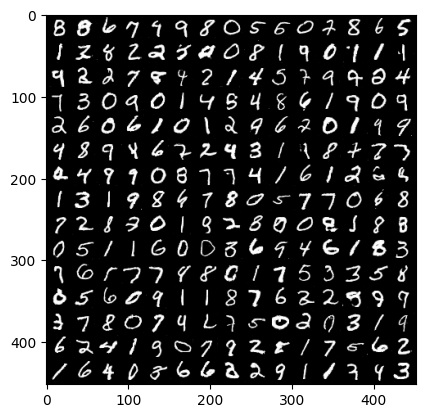

In [ ]:
steps = 0

for epoch in range(50): # for each epoch
    generator_losses = []
    discriminator_losses = []
    mean_real_dis_preds = []
    mean_fake_dis_preds = []

    for im, _ in tqdm(mnist_loader): # for each image in each epoch

        real_ims = im.float().to(device)
        batch_size = real_ims.shape[0]

        ''' ######################### First Optimizing the Discriminator ######################### '''

        optimizer_discriminator.zero_grad()

        fake_im_noise = torch.randn((batch_size, latent_dim), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing the noisy data through the generator to get fake image
        disc_real_pred = discriminator(real_ims) # passing real image to the discriminator
        disc_fake_pred = discriminator(fake_ims.detach()) # passing fake image to the discriminator but we are detaching it so that gradients are not computed for generator and generator is not trained while training the discriminator

        disc_loss = -torch.mean(torch.log(disc_real_pred.reshape(-1) + 0.0001) + torch.log(1. - disc_fake_pred.reshape(-1) + 0.0001) )

        disc_loss.backward()
        optimizer_discriminator.step()

        mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())
        mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())


        ''' ######################### Second Optimizing the Generator ######################### '''
        optimizer_generator.zero_grad()

        fake_im_noise = torch.randn((batch_size, latent_dim), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing through generator to create fake image
        disc_fake_pred = discriminator(fake_ims) # passing through discriminator to classify it as fake or real

        gen_fake_loss = -torch.mean(torch.log(disc_fake_pred.reshape(-1) + 0.0001))

        gen_fake_loss.backward()
        optimizer_generator.step()

        generator_losses.append(gen_fake_loss.item())
        discriminator_losses.append(disc_loss.item())

        ''' ######################### Seeing how the generator is improving with training ######################### '''
        if steps % 5 == 0:
            with torch.no_grad():
                generator.eval()

                NUM_SAMPLES = 225
                fake_im_noise = torch.randn((NUM_SAMPLES, latent_dim), device=device) # generating some noisy data
                fake_ims = generator(fake_im_noise) # generating image using generator
                ims = torch.clamp(fake_ims, -1., 1.).detach().cpu() # clamping the generated images
                ims = 0.5*ims + 0.5 #detransforming the images from [-1,1] to [0,1]
                grid = make_grid(ims, nrow=15)
                img = torchvision.transforms.ToPILImage()(grid)
                plt.imshow(img, cmap='gray') # now display the image here using matplot lib

                generator.train()
        steps += 1

    print(f'''Finished epoch:{epoch + 1} | Generator Loss : {np.mean(generator_losses)} | Discriminator Loss : {np.mean(discriminator_losses)} | Discriminator real pred : {np.mean(mean_real_dis_preds)} | Discriminator fake pred : {np.mean(mean_fake_dis_preds)}''')

Key things to note in above training errors :

1. First discriminator loss decreases while generator loss increases => because initially only discriminator is being trained
2. Then the discriminator loss remains constant and the generator loss decreases => because now the discriminator is freezed and the generator is being trained

# Inference

In [ ]:
NUM_SAMPLES = 225
fake_im_noise = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device) # generating some noisy data
generated_ims = generator(fake_im_noise) # generating image using generator

In [ ]:
generated_ims = torch.clamp(generated_ims, -1., 1.).detach().cpu() # clamping the generated images
generated_ims = 0.5*generated_ims + 0.5 #detransforming the images from [-1,1] to [0,1]

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_ims, nrow=15)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray') # now display the image here using matplot lib